In [1]:
import sys
sys.path.append('../src')

In [2]:
import yaml
import math
import pickle
import numpy as np
from pickle_wrapper import unpickle, pickle_it
import matplotlib.pyplot as plt



from pickle_wrapper import unpickle, pickle_it
from mcmc_norm_learning.algorithm_1_v4 import create_data
from mcmc_norm_learning.rules_4 import get_prob, get_log_prob
from mcmc_norm_learning.environment import position,plot_env
from mcmc_norm_learning.robot_task_new import task, robot, plot_task

In [3]:
with open("../params.yaml", 'r') as fd:
    params = yaml.safe_load(fd)

In [4]:
##Get default env
env = unpickle('../data/env.pickle')

In [5]:
##Get default task
true_norm_exp = params['true_norm']['exp']
num_observations = params['num_observations']
obs_data_set = params['obs_data_set']

colour_specific = params['colour_specific']
shape_specific = params['shape_specific']
target_area_parts = params['target_area'].replace(' ','').split(';')
target_area_part0 = position(*map(float, target_area_parts[0].split(',')))
target_area_part1 = position(*map(float, target_area_parts[1].split(',')))
target_area = (target_area_part0, target_area_part1)
print(target_area_part0.coordinates())
print(target_area_part1.coordinates())
the_task = task(colour_specific, shape_specific,target_area)

(-0.8, 0.7)
(0.25, 0.99)


(0.0, 1.0, 0.0, 1.0)

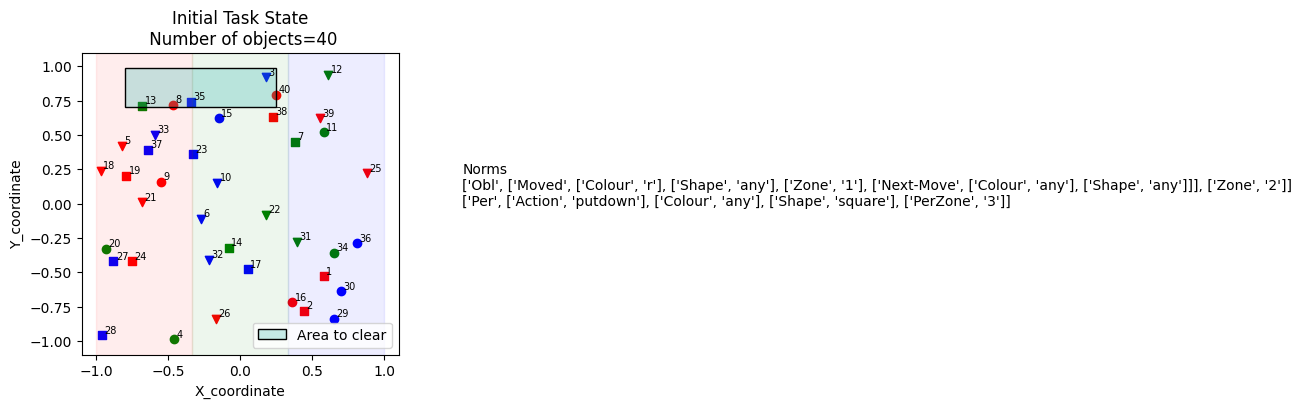

In [6]:
fig,axs=plt.subplots(1,2,figsize=(9,4),dpi=100);
plot_task(env,axs[0],"Initial Task State",the_task,True)
axs[1].text(0,0.5,"\n".join([str(x) for x in true_norm_exp]),wrap=True)
axs[1].axis("off")

### Gen obs using w_nc

In [7]:
comp_obs=unpickle('../data/observations_ad_0.0.pickle')

In [8]:
import random
random.choice([1,2,3])

3

In [9]:
nc_obs= create_data(true_norm_exp,env,name=None,task=the_task,random_task=False,
                               num_actionable=np.nan,num_repeat=50,w_nc=0.1,verbose=False)

Repetition of Task: 100%|██████████| 50/50 [00:00<00:00, 542.85it/s]


### Unit Tests
TEST 1. nc_obs-comp_obs>0 (more often than not)

In [10]:
%%time
%%capture
nc_obs_not_in_old_obs=[]
for itr in range(100):
    nc_obs= create_data(true_norm_exp,env,name=None,task=the_task,random_task=False,
                               num_actionable=np.nan,num_repeat=50,w_nc=0.1,verbose=False)
    nc_obs_not_in_old_obs.append(set(nc_obs)-set(comp_obs))

CPU times: user 6.58 s, sys: 156 ms, total: 6.73 s
Wall time: 6.7 s


In [11]:
sum(map(lambda x: len(x), nc_obs_not_in_old_obs))/100

49.72

TEST 2. Check num violations in indvidual obs
Expected Steady State values
> E[triggers_obs] = (0.1 * trigger % in 3^5 + 0.9 * trigger % in compliant)*num_obs
              = (0.1 * (162/243) + 0.9 * (243-108)/243)*num_obs
> E[viaolation_obs] = (0.1 * violation % in 3^5 + 0.9 * violation % in compliant)*num_obs  
                  = (0.1 * (108/243) + 0.9 * 0/243) *num_obs

In [12]:
((0.1 * (162/243)) + (0.9 * ((243-108)/243)))*100

56.666666666666664

In [13]:
108/243*0.1*100

4.444444444444445

In [14]:
from IPython.utils import io
cnt_norm_trigger_hist=[]
cnt_norm_violated_hist=[]
for itr in range(501):
    with io.capture_output() as captured:
        nc_obs= create_data(true_norm_exp,env,name=None,task=the_task,random_task=False,
                               num_actionable=np.nan,num_repeat=100,w_nc=0.1,verbose=False);
    cnt_norm_trigger=0
    cnt_norm_violated=0
    for obs in nc_obs:
        for action_pairs in zip(obs, obs[1:]):
            if action_pairs[0] in [(('pickup', 8), ('putdown', 8, '1')),(('pickup', 40), ('putdown', 40, '1'))]:
                cnt_norm_trigger+=1
                if action_pairs[1][1][2]=='1': #not in obl zone
                    cnt_norm_violated+=1
                elif action_pairs[1][1][2]=='3':
                    if action_pairs[1][1][1] not in [35,13]: #permission not applicable
                        cnt_norm_violated+=1
                else:
                    continue
    cnt_norm_trigger_hist.append(cnt_norm_trigger)
    cnt_norm_violated_hist.append(cnt_norm_violated)
    if itr%100==0 and itr>0:
        print ("For trials={},\
        avg violations={},\
        avg trigger={}\n".format(itr,sum(cnt_norm_violated_hist)/len(cnt_norm_violated_hist),\
                              sum(cnt_norm_trigger_hist)/len(cnt_norm_trigger_hist)))

For trials=100,        avg violations=2.9504950495049505,        avg trigger=50.89108910891089

For trials=200,        avg violations=2.8805970149253732,        avg trigger=50.37313432835821

For trials=300,        avg violations=2.946843853820598,        avg trigger=50.435215946843854

For trials=400,        avg violations=2.9052369077306732,        avg trigger=50.52618453865337

For trials=500,        avg violations=2.8303393213572856,        avg trigger=50.62075848303393



TEST 3: Likelihood test

In [15]:
from algorithm_2_utilities import Likelihood

In [18]:
nc_obs= create_data(true_norm_exp,env,name=None,task=the_task,random_task=False,
                               num_actionable=np.nan,num_repeat=50,w_nc=0.1,verbose=False)

Repetition of Task: 100%|██████████| 50/50 [00:00<00:00, 641.03it/s]


In [32]:
print ("Non Compliant Obs")
log_post_no_norm=Likelihood(["Norms",["No-Norm"]],the_task,nc_obs,env,w_normative=1-0.1)
log_post_true_norm=Likelihood(true_norm_exp,the_task,nc_obs,env,w_normative=1-0.1)

print(log_post_no_norm,log_post_true_norm)

Non Compliant Obs
-13732.653608350562 -13116.85250284507


In [33]:
print ("Compliant Obs")
log_post_no_norm=Likelihood([],the_task,env,comp_obs)
log_post_true_norm=Likelihood(true_norm_exp,the_task,env,comp_obs)

print(log_post_no_norm,log_post_true_norm)

Compliant Obs


AttributeError: 'tuple' object has no attribute 'position'